# Description of what the model currently does


## Model training
Takes data for each channel and resamples into hourly data
Interpolates to fill the gaps - using linear interpolation
Deletes any nans at the start of the rows
Ensures the dataset contains only full days ie day 1 starts at 0.00 and day n finishes at 2300
Generates a list of all channels
If chosen prints out ACF and APAXF plots for each (would be good to have this as data rather than just a plot so we can use it)

Dataset split into final test (24 hour out of sample test set), 7 day/168 hour validation set and all that comes before training set

For each channel 'flatten' the training set into a series of 24 X no of days known as 'history'
create a config list - in this case it is made up of the different combinations in sarima configs ie order,sorder and trend

Using the sarmia params function generate a list of all configurations to be attempted

Run a grid search using the model, the train and test data and the configuration

Run through the Score model function. This tries the evaluate_model using each configuration of sarima config to generate a result. If there are any errors it ignores but if value is generated it restates the model and its score for that channel

Evaluate model function this takes history which is equal to the training set ie a number of lists each 24 hours in length. It then flattens the array to create a long list equal to history. Then for each of the 7 days in the test set it trains the model on the history data and the current configuration and generates a prediction of 24 hours. THis is added to the predctions list. Finally day i is added to history and included in the data that is used to train day i+1. This continues through each of the 7 days. At the end of each day a set of 24 scores is compared with the actual value for the next day. These are listed as SCORES.

Teh evaluate model then takes the two 7 X 74 arrays ie actual and prediction and calculates the mse/rmse of the whole by taking the root of the mean squared difference between the two. THis gives SCORE

Finally sort the configurations and scores in order with lowest at the top, print the first five. 
Best config is the top ie the configuration with the lowest score over the test array
This is the model to be used.

## Forecasting

THis would be updated hourly

THis takes in use inputs of date and device (in the future this will be gps driven)
The channel selects the best configuration which has been set for the week in the model above

The sarima model then runs on the historical data and using the best model to generate a 24 hour prediction
The model at this stage also includes a 95% confidence interval limits.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error

from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import datetime
import time 

import psutil
import ast

In [71]:
sns.set_style("white", {'axes.grid' : False})
sns.set_palette("tab20", 16)
sns.set(font="Calibri")
sns.set_context('talk')

 List of available channels:
        
Channel:  aq_04
Channel:  aq_05
Channel:  aq_06
Channel:  aq_07
Channel:  aq_08
Channel:  aq_09
Channel:  aq_10
Channel:  aq_11
Channel:  aq_13
Channel:  aq_14
Channel:  aq_15
Channel:  aq_16
Channel:  aq_17
Channel:  aq_18
Channel:  aq_20
Channel:  aq_21
Channel:  aq_22
Channel:  aq_23
Channel:  aq_24
Channel:  aq_25
Channel:  aq_26
Channel:  aq_27
Channel:  aq_29
Channel:  aq_30
Channel:  aq_31
Channel:  aq_32
Channel:  aq_33
Channel:  aq_34
Channel:  aq_35
Channel:  aq_36
Channel:  aq_39
Channel:  aq_40
Channel:  aq_41
Channel:  aq_43
Channel:  aq_44
Channel:  aq_45
Channel:  aq_46
Channel:  aq_47
Channel:  aq_48
Channel:  aq_49

# Running the  model for each dataset

# FUNCTIONS

In [72]:
hourly_data = pd.read_csv('hourly_data_AUG_19.csv', parse_dates=['time'])

In [73]:
hourly_data

,channel,time,pm_2_5
0,aq_04,2019-01-12 14:00:00+03:00,24.143333
1,aq_04,2019-01-12 15:00:00+03:00,21.483333
2,aq_04,2019-01-12 16:00:00+03:00,NaN
3,aq_04,2019-01-12 17:00:00+03:00,NaN
4,aq_04,2019-01-12 18:00:00+03:00,NaN
...,...,...,...
165775,aq_49,2019-09-02 13:00:00+03:00,22.874000
165776,aq_49,2019-09-02 14:00:00+03:00,19.804444
165777,aq_49,2019-09-02 15:00:00+03:00,29.308222
165778,aq_49,2019-09-02 16:00:00+03:00,21.411429


In [74]:
def full_days_only(d):
    ###  Interpolating gaps within the data and presenting in necessary format ####
    d = d.set_index('time')
    d = d.interpolate(method='time');
#     print(d)
    # drop any remaining nans from the start
    d =  d.dropna().reset_index();
    # Setting first complete day and last complete day to assist with training quality
    first_full_day = pd.to_datetime(d.loc[d.time.dt.hour == 0.00, 'time'][:1].values[0], utc=True)
    last_full_day = pd.to_datetime(d.loc[d.time.dt.hour == 23.00, 'time'][-1:].values[0], utc=True)  
    # THen correct Kampala values are applied
    d_whole_days = d.loc[(d.time >= first_full_day) & (d.time <= last_full_day)]
    d_whole_days = d_whole_days.set_index('time')
#     print(d_whole_days)
    return d_whole_days

In [75]:
# THis should be unecessary but every time i take it out it causes issues
def out_of_sample(d, oos_size):
    df = d.iloc[:-oos_size, 1]
    oos = d.iloc[-oos_size:, 1]
    return df, oos

In [76]:
# Creating a list of channels to iterate through
chanlist = hourly_data.channel.unique().tolist()

In [77]:
def plot_acf_pcf(df, lags):
    # plots specifying number of lags to includ
    plt.figure(figsize=(20,6))
    # acf
    axis = plt.subplot(2, 1, 1)
    plot_acf(df, ax=axis, lags=lags)
    # pacf
    axis = plt.subplot(2, 1, 2)
    plot_pacf(df, ax=axis, lags=lags)
    # show plot
#     print(chan)
    plt.show()

In [78]:
for chan in chanlist:
    d = hourly_data.loc[hourly_data.channel == chan, ['time','pm_2_5']]
#     print(d)
    df = full_days_only(d)
#     print('Channel: ', chan)
    # USE THIS IF WANT TO GENERATE AUTOCORRELATION GRAPHS
#     plot_acf_pcf(df, 24)

# Preparing data for forecast model

In [79]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks with 1 week validation and 1 day oos test
    train, test = data[0:-192], data[-192:-24]
    final_test = data[-24:]
    # restructure into windows of weekly data
    train = array(split(train, (len(train)/24)))
    test = array(split(test, (len(test)/24)))
#     print(train, test, final_test)
    return train, test, final_test

In [80]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
    # extract just the total power from each week
    series = [day for day in data]
    # flatten into a single series
    series = array(series).flatten()
#     print('series.shape: ', series.shape)
    return series

In [81]:
# sarima forecast
# Takes the history (train set plus day by day testing) and configuration
# converts history values to a single long series
# generates the sarima model based on config parameters
# fits the sarima model to the series data
# creates yhat, a prediction of the next 24 hours int he test set
def sarima_forecast(history, config):
    order, sorder, trend = config
    # convert history into a univariate series
    series = to_series(history)
    # define model
    model = SARIMAX(series, order=order, seasonal_order=sorder, trend = trend,enforce_stationarity=False, enforce_invertibility=False)
#     model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(series), len(series)+23)
    return yhat

In [82]:
# evaluate a single model which creates a prediction for ech day and each hour
# This is then fed into the evaluate forecast function to generate overall scores for the model
# for the model
# This needs to happen for every incarnation of the model
def evaluate_model(model_func, train, test, config):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week

        yhat_sequence = model_func(history, config)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test, predictions)
    return score, scores

In [83]:
def evaluate_forecasts(actual, predicted):
#     print('actual.shape : ', actual.shape)
#     print('predicted.shape', predicted.shape)
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        print('i', i)
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        print('mse', mse)
        # calculate rmse
        rmse = sqrt(mse)
        print('rmse', rmse)
        # store
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
#     return score, scores
#     print('score, scores: ', score, scores)

    return score, scores

In [84]:
# summarize scores
#Takes the name, model score and list of hourley mean scores
#print
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f]' % (name, score))

In [85]:
# create a set of sarima configs to try
def sarima_configs():
    models = list()
    # define config lists
#     p_params = [0,1,2]
    p_params = [2]
    d_params = [0]
#     q_params = [0,1,2]        
    q_params = [24]
#     t_params = ['n','c','t','ct']
    t_params = ['c']
    P_params = [1]
    D_params = [0]
    Q_params = [1]
    m_params = [24]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [86]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [87]:
# grid search configs
# Using train, test data and the list of configurations
# working in parallel


# def grid_search(data, cfg_list, n_test, parallel=True):
def grid_search(model_func, train, test, cfg_list, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing', verbose=1)
#         executor = Parallel(n_jobs=psutil.cpu_count(), verbose=1)
        tasks = (delayed(score_model)(model_func,train, test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
#         print('scores2', scores)
    else:
        scores = [score_model(model_func,train, test, cfg) for cfg in cfg_list]
#         print('scores1', scores)
    # remove empty results
#     print('scores', scores)
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [88]:
# score a model, return None on failure

def score_model(model_func,train, test, cfg, debug=False):
#     print('score_model')
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
#         result = walk_forward_validation(data, n_test, cfg)
        result = evaluate_model(model_func,train, test, cfg)[0]
#         print('DEBUG')
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = evaluate_model(model_func,train, test, cfg)[0]
#                 print('RESULT')
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [89]:
def train_channels_in_range_inclusive(a, b):
# Generating a dataframe for each channel
    best_config_dict = {}
#     for chan in chanlist[lower_limit:(upper_limit+1)]:
    for chan in chanlist[a:b]:
    #     # selecting only rows relating to the given channel
        d = hourly_data.loc[hourly_data.channel == chan]
    #    # removing partial days at start and end of sample
        df = full_days_only(d)
        # set size of out of sample test data
        oos_size = 24
        df, oos = out_of_sample(df, oos_size)
        # Generating train and test
        train, test, final_test = split_dataset(df)[0:3]
    
        # define the names and functions for the models we wish to evaluate
        models = dict()
        models['sarima'] = sarima_forecast

        print('channel', chan)
        # model configs
        n_test = 24
        cfg_list = sarima_configs()
        # print(cfg_list)
        # grid search
    #     count=0
        scores = grid_search(sarima_forecast, train, test, cfg_list)
#     print('channel: '+str(chan) +' done')
        # list top 3 configs
        for cfg, error in scores[:5]:
            print(cfg, error)
    #     print('SCORES',scores)    
        # best_config = scores[:1]
        best_config = ast.literal_eval(scores[:1][0][0])
        print('best config', best_config)
        ## For calculating out of sample score
#         best_oos_yhat = sarima_forecast(df, best_config)
#         oos_rmse = measure_rmse(final_test, best_oos_yhat)
#         print('Out of sample rmse: ', oos_rmse)
        # Add best config to the current best_config_dict
        best_config_dict[chan] = best_config
        print(best_config_dict)
        return best_config, best_config_dict

In [90]:
# # Generating a dataframe for each channel
# for chan in chanlist[21:24]:
# #     # selecting only rows relating to the given channel
# #     d = data_grp_hourly.loc[data_grp_hourly.channel == chan]
#         # selecting only rows relating to the given channel
#     d = hourly_data.loc[hourly_data.channel == chan]
# #     print(d)
# #    # removing partial days at start and end of sample
# #     df = df.reset_index()
#     df = full_days_only(d)
# #     print('df', df)

#     # set size of out of sample test data
#     oos_size = 24
#     df, oos = out_of_sample(df, oos_size)
#     # Generating train and test
#     train, test, final_test = split_dataset(df)[0:3]


#     #Checking the size of the train and test sets
# #     print('train shape: ', train.shape)
# #     print('test shape: ', test.shape)
# #     print('final test shape',final_test.shape)
    
#     # define the names and functions for the models we wish to evaluate
#     models = dict()
#     models['sarima'] = sarima_forecast

#     # name each hour to be aggregated
# #     hours = ['0', '1', '2', '3', '4', '5', '6', '7', '8','9','10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
#     print('channel', chan)
#     # data split
#     n_test = 24
#     # model configs
#     cfg_list = sarima_configs()
# #     print(cfg_list)
#     # grid search
# #     count=0
#     scores = grid_search(sarima_forecast, train, test, cfg_list)
# #     print('channel: '+str(chan) +' done')
#     # list top 3 configs
#     for cfg, error in scores[:5]:
#         print(cfg, error)
#     # print('SCORES',scores)    
#     # best_config = scores[:1]
#     best_config = ast.literal_eval(scores[:1][0][0])
# #     print('best config', best_config)
# #     best_oos_yhat = sarima_forecast(df, best_config)
# #     oos_rmse = measure_rmse(final_test, best_oos_yhat)
# #     print('Out of sample rmse: ', oos_rmse)

In [91]:
train_channels_in_range_inclusive(0,2)

channel aq_04


[Parallel(n_jobs=64)]: Using backend MultiprocessingBackend with 64 concurrent workers.


i 0
mse 49.30182812109195
rmse 7.021526053579232
i 1
mse 61.5520653882548
rmse 7.845512436307446
i 2
mse 66.69005282364749
rmse 8.16639778749771
i 3
mse 84.97644509376498
rmse 9.218266924632037
i 4
mse 88.50996574365873
rmse 9.407973519502418
i 5
mse 93.75622136795658
rmse 9.682779630248568
i 6
mse 108.69353899270581
rmse 10.425619357750685
i 7
mse 133.33458385779252
rmse 11.547059532963036
i 8
mse 164.2765734367841
rmse 12.817042304556232
i 9
mse 204.47584820248298
rmse 14.299505173343691
i 10
mse 297.36838606161695
rmse 17.24437259112714
i 11
mse 359.2100164024293
rmse 18.952836632083052
i 12
mse 517.680070422229
rmse 22.752583818595834
i 13
mse 562.1873733490851
rmse 23.710490786761145
i 14
mse 366.43266593446185
rmse 19.142431035123565
i 15
mse 544.6716430204025
rmse 23.338201366437872
i 16
mse 590.13376765049
rmse 24.292669010433784
i 17
mse 404.18241322776396
rmse 20.10428842878464
i 18
mse 1036.423892267247
rmse 32.19353805140477
i 19
mse 3570.9242780893273
rmse 59.7572110969824

[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed: 53.1min finished


[(2, 0, 24), (1, 0, 1, 24), 'c']

In [92]:
best_config_dict

{'aq_22': [(2, 0, 24), (1, 0, 1, 24), 'c'],
 'aq_23': [(2, 0, 24), (0, 0, 1, 24), 'c'],
 'aq_24': [(5, 0, 24), (0, 0, 0, 24), 'c']}

# Forecasting

In [33]:
best_config_dict = {'aq_22': [(2, 0, 24), (1, 0, 1, 24), 'c'] , 'aq_23': [(2, 0, 24), (0, 0, 1, 24), 'c'], 'aq_24': [(5, 0, 24), (0, 0, 0, 24), 'c'] }

In [5]:
enter_time = input("Enter a valid date and time (yyyy/mm/dd/hh)   ")

Enter a valid date and time (yyyy/mm/dd/hh)    2019/07/08/07


In [53]:
enter_chan = input("Enter a valid channel name: ")

Enter a valid channel name:  aq_24


In [54]:
current_best_config = best_config_dict.get(str(enter_chan))
print(current_best_config)

[(5, 0, 24), (0, 0, 0, 24), 'c']


In [55]:
# Wrnagling the user input date formats to get a datetime
enter_time_split = enter_time.split("/")
enter_time_tuple = tuple([int(i) for i in enter_time_split])
endings = (0,0,0,0,0,)
start_time = (enter_time_tuple + endings)
start_pred_time = datetime.datetime.fromtimestamp(time.mktime(start_time))
print(start_pred_time)

2019-07-08 07:00:00


In [56]:
# interpolating, removing nans and dropping columns
def fill_gaps_and_set_datetime(d):
    # Interpolating gaps within the data
    d = d.set_index('time')
    d = d.drop('channel', axis=1)
    d_cleaned = d.interpolate(method='time');
    return d_cleaned

In [57]:
# sarima forecast
# Takes the history (train set plus day by day testing) and configuration
# converts history values to a single long series
# generates the sarima model based on config parameters
# fits the sarima model to the series data
# creates yhat, a prediction of the next 24 hours int he test set
def sarima_forecast(history, config):
    order, sorder, trend = config
    # convert history into a univariate series
    series = to_series(history)
    # define model
    model = SARIMAX(series, order=order, seasonal_order=sorder, trend = trend,enforce_stationarity=False, enforce_invertibility=False)
#     model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast using predict method
#     yhat = model_fit.predict(len(series), len(series)+23)
    # This does th same thing but using forecast which has slightly different features
    fcst = model_fit.get_forecast(24)
    # Generating list of mean forecasts
    yhat = fcst.predicted_mean
    # Generating confidence intervals
    yhat_ci = fcst.conf_int()
    return yhat, yhat_ci

In [58]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
    # extract just the total power from each week
    series = [day for day in data]
    # flatten into a single series
    series = array(series).flatten()
#     print('series.shape: ', series.shape)
    return series

In [59]:
def new_forecast(enter_chan, enter_time):

    current_best_config = best_config_dict.get(str(enter_chan))
    # converting the start prediction time to datetime
    start_pred = (pd.to_datetime(start_pred_time))

    # select all data relating to a particular channel
    all_channel_data = hourly_data.loc[hourly_data.channel == enter_chan]

    # clean the channel data, fill gaps and set datetime as index
    all_channel_data_clean = fill_gaps_and_set_datetime(all_channel_data)

    # set start time as being 8 weeks before start of forecast
    # THis will need to be changed to max number of whole days

    ####TODO #######
    start_base_time = str(start_pred - datetime.timedelta(84)) +'+3:00'
    start_pred = str(start_pred) +'+3:00'
    print((start_base_time))
    print((start_pred))
    # select final range of data to be used in forecast
    data_to_use = all_channel_data_clean.loc[start_base_time:(start_pred)].values

    yhat, yhat_ci = sarima_forecast(data_to_use, current_best_config)

    return start_pred, yhat, yhat_ci

In [60]:
start_pred, yhat, yhat_ci = new_forecast(enter_chan, enter_time)

2019-04-15 07:00:00+3:00
2019-07-08 07:00:00+3:00


/home/jupyter/.local/lib/python3.5/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [61]:
yhat

array([73.8036935 , 62.79889693, 53.61454609, 45.59073745, 38.39856156,
       34.69679838, 31.4991545 , 31.90920154, 34.28567136, 34.10740482,
       35.82106677, 41.69327337, 46.28875853, 47.32628035, 46.08810145,
       45.60361595, 47.32874082, 49.30787672, 51.84079022, 55.03844973,
       59.28518738, 62.13723576, 62.74524275, 62.13472892])

In [62]:

forecast = pd.DataFrame(list(zip(yhat, yhat_ci)))
forecast.columns = ['yhat', 'yhat_ci']
# Splitting confidence intercals into upper and lower bounds
forecast['yhat_lower_ci'] = [pair[0] for pair in forecast.yhat_ci]
forecast['yhat_upper_ci']  = [pair[1] for pair in forecast.yhat_ci]
# adjusting column names and dropping combinded ci
forecast.columns = ['yhat', 'yhat_ci','yhat_lower_ci', 'yhat_upper_ci']
forecast = forecast.drop('yhat_ci', axis=1);

# Generating dataframe including the actual hours predicted
start_pred_hour = pd.to_datetime(start_pred).hour +1
pred_hours = [(x + start_pred_hour)%24 for x in np.arange(24)]
forecast['pred_hours'] = pred_hours

forecast

,yhat,yhat_lower_ci,yhat_upper_ci,pred_hours
0,73.803694,59.134602,88.472785,8
1,62.798897,44.455676,81.142118,9
2,53.614546,33.438928,73.790165,10
3,45.590737,24.274221,66.907254,11
4,38.398562,16.432129,60.364994,12
5,34.696798,12.495264,56.898333,13
6,31.499154,9.206031,53.792278,14
7,31.909202,9.614751,54.203652,15
8,34.285671,11.984435,56.586908,16
9,34.107405,11.805421,56.409388,17


[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7]


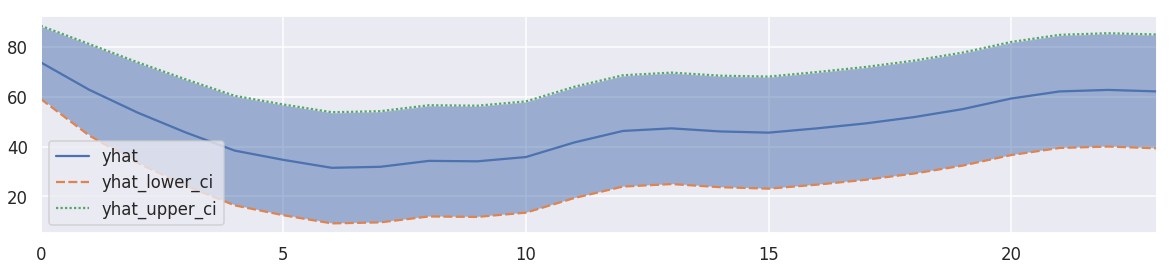

In [69]:
# Plotting forecasts and confidence intervals - why are they fixed?
fig, ax = plt.subplots(figsize=(20,4))
sns.lineplot(data= forecast.iloc[:, :3])
hours_order = list(forecast.pred_hours)
print(hours_order)
plt.fill_between(forecast.index,forecast.yhat_lower_ci, forecast.yhat_upper_ci, alpha=0.5)
plt.xlim(0,23)
# ax.set_xticklabels(labels=hours_order)
plt.show()

NameError: name 'all_channel_data_clean' is not defined

In [7]:
ranger = np.arange(24)

In [9]:
ranger[2:6]

array([2, 3, 4, 5])